In [156]:
import numpy as np
import pandas as pd
import seaborn as sns
import torch

from utils import *
from fancyimpute import SimpleFill, KNN, SoftImpute, IterativeSVD, MatrixFactorization, NuclearNormMinimization, BiScaler
from scipy import stats
from matplotlib import pyplot as plt
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
sns.set(rc={'figure.figsize':(11.7,8.27)})

In [157]:
np.random.seed(0)

In [158]:
# Function produce_NA for generating missing values ------------------------------------------------------

def produce_NA(X, p_miss, mecha="MCAR", opt=None, p_obs=None, q=None):
    """
    Generate missing values for specifics missing-data mechanism and proportion of missing values. 
    
    Parameters
    ----------
    X : torch.DoubleTensor or np.ndarray, shape (n, d)
        Data for which missing values will be simulated.
        If a numpy array is provided, it will be converted to a pytorch tensor.
    p_miss : float
        Proportion of missing values to generate for variables which will have missing values.
    mecha : str, 
            Indicates the missing-data mechanism to be used. "MCAR" by default, "MAR", "MNAR" or "MNARsmask"
    opt: str, 
         For mecha = "MNAR", it indicates how the missing-data mechanism is generated: using a logistic regression ("logistic"), quantile censorship ("quantile") or logistic regression for generating a self-masked MNAR mechanism ("selfmasked").
    p_obs : float
            If mecha = "MAR", or mecha = "MNAR" with opt = "logistic" or "quanti", proportion of variables with *no* missing values that will be used for the logistic masking model.
    q : float
        If mecha = "MNAR" and opt = "quanti", quantile level at which the cuts should occur.
    
    Returns
    ----------
    A dictionnary containing:
    'X_init': the initial data matrix.
    'X_incomp': the data with the generated missing values.
    'mask': a matrix indexing the generated missing values.s
    """
    
    to_torch = torch.is_tensor(X) ## output a pytorch tensor, or a numpy array
    if not to_torch:
        X = X.astype(np.float32)
        X = torch.from_numpy(X)
    
    if mecha == "MAR":
        mask = MAR_mask(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "logistic":
        mask = MNAR_mask_logistic(X, p_miss, p_obs).double()
    elif mecha == "MNAR" and opt == "quantile":
        mask = MNAR_mask_quantiles(X, p_miss, q, 1-p_obs).double()
    elif mecha == "MNAR" and opt == "selfmasked":
        mask = MNAR_self_mask_logistic(X, p_miss).double()
    else:
        mask = (torch.rand(X.shape) < p_miss).double()
    
    X_nas = X.clone()
    X_nas[mask.bool()] = np.nan
    
    return {'X_init': X.double(), 'X_incomp': X_nas.double(), 'mask': mask}

# EDA

In [198]:
data = pd.read_csv('trainSet.txt')

In [199]:
# N full rows
len(data.dropna())

6

In [200]:
# Percentage of missigness
round(data.isna().sum()/len(data), 2)

PatientID                0.00
ImageFile                0.00
Hospital                 0.00
Age                      0.00
Sex                      0.00
Temp_C                   0.18
Cough                    0.01
DifficultyInBreathing    0.00
WBC                      0.01
CRP                      0.04
Fibrinogen               0.68
LDH                      0.16
Ddimer                   0.72
Ox_percentage            0.28
PaO2                     0.20
SaO2                     0.68
pH                       0.24
CardiovascularDisease    0.02
RespiratoryFailure       0.18
Prognosis                0.00
dtype: float64

In [201]:
def preprocess(df, drop = True):
    dataDropped = df.drop(['Ddimer', 'SaO2', 'Fibrinogen', 'Prognosis', 'PatientID', 'ImageFile', 'Hospital'], axis = 1)
    if drop:
        dataDropped = dataDropped.dropna()
    # Binary variables (Hackathon description_26_04.pdf)
    dataDropped['Cough'] = pd.factorize(dataDropped['Cough'])[0]
    dataDropped['Sex'] = pd.factorize(dataDropped['Sex'])[0]
    dataDropped['DifficultyInBreathing'] = pd.factorize(dataDropped['DifficultyInBreathing'])[0]
    dataDropped['CardiovascularDisease'] = pd.factorize(dataDropped['CardiovascularDisease'])[0]
    dataDropped['RespiratoryFailure'] = pd.factorize(dataDropped['RespiratoryFailure'])[0]
    return dataDropped

def standardize(df):
    return ((df - df.mean())/df.std())

In [202]:
def generateMissingData(df, p_miss=0.3):
    processed = preprocess(df)
#     standardized = standardize(processed)
    res = produce_NA(processed.to_numpy(), p_miss=p_miss, mecha="MCAR")
    res['X_init'] = pd.DataFrame(res['X_init'].numpy())
    res['X_init'].columns = processed.columns
    res['X_incomp'] = pd.DataFrame(res['X_incomp'].numpy())
    res['X_incomp'].columns = processed.columns
    res['mask'] = pd.DataFrame(res['mask'].numpy())
    res['mask'].columns = processed.columns
    return res

In [212]:
def evaluate(data, algorithm):
    msk = np.random.rand(len(data)) < 0.8
    train = preprocess(data[msk], drop = False)
    test = data[~msk]
    full_data, missed_data, _ = generateMissingData(test).items()
    algorithm.fit(train)
    restored_data = algorithm.transform(missed_data[1])
    return np.linalg.norm(restored_data-full_data[1], ord = 2)

In [221]:
data

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_131,P_131.png,D,35.913889,0,39.3,1.0,0.0,5.76,43.40,651.0,387.0,157.0,94.0,NaN,NaN,NaN,0.0,NaN,MILD
1,P_132,P_132.png,D,57.266667,0,37.0,0.0,0.0,11.48,64.00,700.0,338.0,601.0,94.0,75.0,96.9,7.42,0.0,NaN,MILD
2,P_195,P_195.png,D,79.263889,0,37.8,1.0,0.0,6.21,115.30,698.0,356.0,448.0,94.0,63.0,94.6,7.39,1.0,NaN,SEVERE
3,P_193,P_193.png,D,82.000000,0,38.0,1.0,0.0,7.28,149.30,513.0,482.0,NaN,97.0,68.0,96.3,7.46,0.0,NaN,SEVERE
4,P_140,P_140.png,D,60.791667,1,37.0,1.0,0.0,6.37,20.70,NaN,NaN,210.0,93.0,NaN,97.3,NaN,0.0,NaN,MILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,P_1_12,P_1_12.png,F,51.000000,0,NaN,0.0,1.0,14.30,22.79,550.0,368.0,5027.0,NaN,NaN,NaN,NaN,0.0,0.0,SEVERE
859,P_1_8,P_1_8.png,F,57.000000,0,NaN,1.0,0.0,5.10,8.93,757.0,451.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,SEVERE
860,P_1_10,P_1_10.png,F,38.000000,0,NaN,0.0,1.0,7.30,0.23,NaN,NaN,1073.0,NaN,NaN,NaN,NaN,0.0,0.0,MILD
861,P_1_26,P_1_26.png,F,92.000000,1,38.0,0.0,1.0,13.50,3.77,533.0,358.0,2154.0,NaN,75.7,NaN,7.36,0.0,0.0,SEVERE


## Main Benchmark

In [223]:
algorithms = {
    "SimpleFill": SimpleImputer(),
    "KNN-23": KNNImputer(n_neighbors=23),
    "KNN-24": KNNImputer(n_neighbors=24),
    "KNN-25": KNNImputer(n_neighbors=25),
    "KNN-26": KNNImputer(n_neighbors=26),
    "KNN-27": KNNImputer(n_neighbors=27),
    "KNN-28": KNNImputer(n_neighbors=28),
    "KNN-30": KNNImputer(n_neighbors=30),
    "KNN-40": KNNImputer(n_neighbors=40),
    "KNN-50": KNNImputer(n_neighbors=50),

}

benchmarkResults = {algorithm: [] for algorithm in algorithms}

In [205]:
train = pd.read_csv('trainSet.txt')
test = pd.read_csv('testSet.txt')

In [206]:
train = preprocess(train, drop = False)
test = preprocess(test, drop = False)

In [207]:
model = KNNImputer(n_neighbors=25)

In [208]:
test = model.fit(train).transform(test)

In [171]:
test = pd.DataFrame(test, columns=train.columns)

In [172]:
test.to_csv('testSet_filled.txt')

In [224]:
for algorithm in algorithms:
    print("Start with {}".format(algorithm))
    for k in range(1000):
        benchmarkResults[algorithm].append(evaluate(data, algorithms[algorithm]))
    print("End with {}".format(algorithm))
        

Start with SimpleFill
End with SimpleFill
Start with KNN-23
End with KNN-23
Start with KNN-24
End with KNN-24
Start with KNN-25
End with KNN-25
Start with KNN-26
End with KNN-26
Start with KNN-27
End with KNN-27
Start with KNN-28
End with KNN-28
Start with KNN-30
End with KNN-30
Start with KNN-40
End with KNN-40
Start with KNN-50
End with KNN-50


In [219]:
for algorithm in algorithms:
    print("Result for algorithm {}".format(algorithm))
    print("Mean: {}".format(np.mean(benchmarkResults[algorithm])))
    print("Median: {}".format(np.median(benchmarkResults[algorithm])))
    print('\n')


Result for algorithm SimpleFill
Mean: 985.3932867335611
Median: 709.140200066272


Result for algorithm KNN-23
Mean: 853.5637882074602
Median: 680.9808283148916


Result for algorithm KNN-24
Mean: 982.0797627245759
Median: 715.6341365849203


Result for algorithm KNN-25
Mean: 848.1968948985237
Median: 638.6300282656626


Result for algorithm KNN-26
Mean: 986.6459099889923
Median: 727.8552327264215


Result for algorithm KNN-27
Mean: 800.0196217282323
Median: 604.084771550431


Result for algorithm KNN-28
Mean: 834.5182183608305
Median: 662.4704828324227


Result for algorithm KNN-30
Mean: 898.7575016262568
Median: 650.898587142188


Result for algorithm KNN-40
Mean: 825.9095897764898
Median: 632.1779674047141


Result for algorithm KNN-50
Mean: 827.1251191518429
Median: 638.2160248631557




## Plot

In [85]:
def plot(m):
    dfs = []
    for key in m:
        dfs.append(pd.DataFrame(np.reshape(np.array(m[key]), (-1, 1))).assign(Algorithm=key))
    cdf = pd.concat(dfs)
    mdf = pd.melt(cdf, id_vars=['Algorithm'])
    mdf.rename(columns={"value": "MSE"}, inplace=True)
    ax = sns.boxplot(x="Algorithm", y="MSE", data=mdf)  # RUN PLOT   
#     plt.savefig("result.jpg")
    plt.show()

    plt.clf()

    plt.close()  

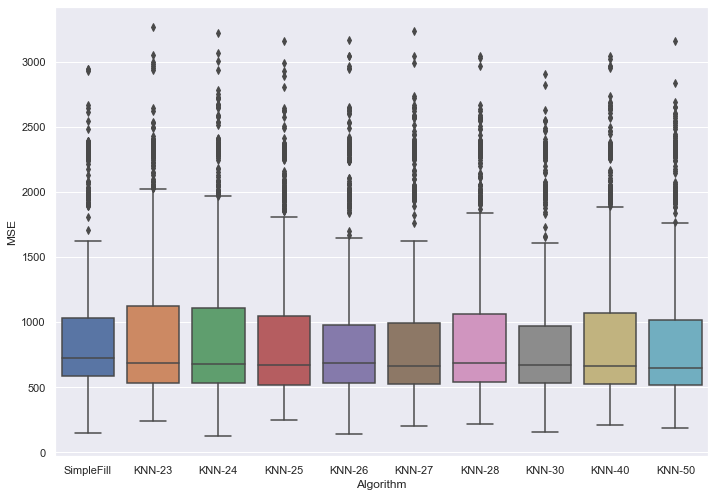

In [225]:
plot(benchmarkResults)

# Iterative Imputer with multiple regressors/estimators

In [87]:
iterativeImputers = {
    'BayesianRidge': IterativeImputer(random_state=0, estimator=BayesianRidge()),
    'DecisionTreeRegressor': IterativeImputer(random_state=0, estimator=DecisionTreeRegressor(max_features='sqrt', random_state=0)),
    'ExtraTreesRegressor': IterativeImputer(random_state=0, estimator=ExtraTreesRegressor(n_estimators=10, random_state=0)),
#     'KNeighborsRegressor': KNeighborsRegressor(n_neighbors=15)
}

iterativeBenchmarkResults = {iterativeImputer: [] for iterativeImputer in iterativeImputers}

for iterativeImputer in iterativeImputers:
    print("Start with {}".format(iterativeImputer))
    for k in range(100):
        iterativeBenchmarkResults[iterativeImputer].append(evaluate(data, iterativeImputers[iterativeImputer]))
    print("End with {}".format(iterativeImputer))


Start with BayesianRidge
End with BayesianRidge
Start with DecisionTreeRegressor
End with DecisionTreeRegressor
Start with ExtraTreesRegressor
End with ExtraTreesRegressor


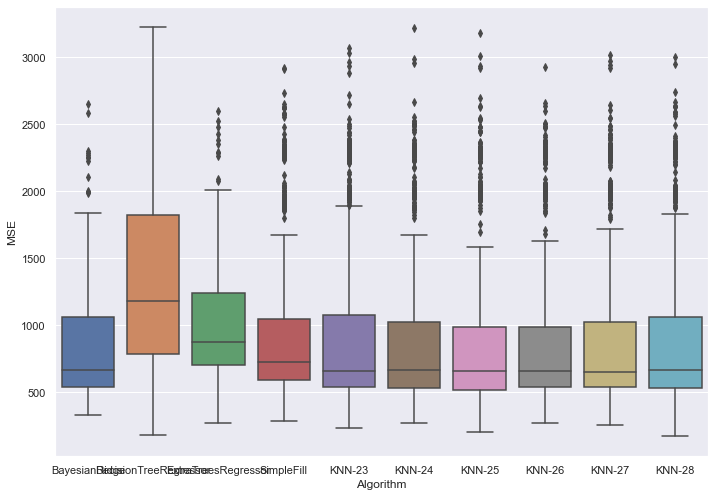

In [88]:
plot(dict(list(iterativeBenchmarkResults.items()) + list(benchmarkResults.items())))

In [226]:
data

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_131,P_131.png,D,35.913889,0,39.3,1.0,0.0,5.76,43.40,651.0,387.0,157.0,94.0,NaN,NaN,NaN,0.0,NaN,MILD
1,P_132,P_132.png,D,57.266667,0,37.0,0.0,0.0,11.48,64.00,700.0,338.0,601.0,94.0,75.0,96.9,7.42,0.0,NaN,MILD
2,P_195,P_195.png,D,79.263889,0,37.8,1.0,0.0,6.21,115.30,698.0,356.0,448.0,94.0,63.0,94.6,7.39,1.0,NaN,SEVERE
3,P_193,P_193.png,D,82.000000,0,38.0,1.0,0.0,7.28,149.30,513.0,482.0,NaN,97.0,68.0,96.3,7.46,0.0,NaN,SEVERE
4,P_140,P_140.png,D,60.791667,1,37.0,1.0,0.0,6.37,20.70,NaN,NaN,210.0,93.0,NaN,97.3,NaN,0.0,NaN,MILD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
858,P_1_12,P_1_12.png,F,51.000000,0,NaN,0.0,1.0,14.30,22.79,550.0,368.0,5027.0,NaN,NaN,NaN,NaN,0.0,0.0,SEVERE
859,P_1_8,P_1_8.png,F,57.000000,0,NaN,1.0,0.0,5.10,8.93,757.0,451.0,NaN,NaN,NaN,NaN,NaN,0.0,0.0,SEVERE
860,P_1_10,P_1_10.png,F,38.000000,0,NaN,0.0,1.0,7.30,0.23,NaN,NaN,1073.0,NaN,NaN,NaN,NaN,0.0,0.0,MILD
861,P_1_26,P_1_26.png,F,92.000000,1,38.0,0.0,1.0,13.50,3.77,533.0,358.0,2154.0,NaN,75.7,NaN,7.36,0.0,0.0,SEVERE


In [227]:
def preprocess_fix(df, drop = True, good_only = True):
    dataDropped = df.drop(['Prognosis', 'PatientID', 'ImageFile', 'Hospital'], axis = 1)
    if good_only:
        dataDropped = df.drop(['Ddimer', 'SaO2', 'Fibrinogen'], axis = 1)
    if drop:
        dataDropped = dataDropped.dropna()
    dataDropped['Cough'] = pd.factorize(dataDropped['Cough'])[0]
    dataDropped['Sex'] = pd.factorize(dataDropped['Sex'])[0]
    dataDropped['DifficultyInBreathing'] = pd.factorize(dataDropped['DifficultyInBreathing'])[0]
    dataDropped['CardiovascularDisease'] = pd.factorize(dataDropped['CardiovascularDisease'])[0]
    dataDropped['RespiratoryFailure'] = pd.factorize(dataDropped['RespiratoryFailure'])[0]
    return dataDropped

In [228]:
train = pd.read_csv('trainSet.txt')
test = pd.read_csv('testSet.txt')

In [229]:
train.columns

Index(['PatientID', 'ImageFile', 'Hospital', 'Age', 'Sex', 'Temp_C', 'Cough',
       'DifficultyInBreathing', 'WBC', 'CRP', 'Fibrinogen', 'LDH', 'Ddimer',
       'Ox_percentage', 'PaO2', 'SaO2', 'pH', 'CardiovascularDisease',
       'RespiratoryFailure', 'Prognosis'],
      dtype='object')

In [238]:
train_bad_columns = train[['Ddimer', 'SaO2', 'Fibrinogen']]
test_bad_columns = test[['Ddimer', 'SaO2', 'Fibrinogen']]

train_good_columns = preprocess(train, drop=False)
test_good_columns = preprocess(test, drop=False)

In [235]:
train_bad_columns
round(train_bad_columns.isna().sum()/len(train_bad_columns), 2)

Ddimer        0.72
SaO2          0.68
Fibrinogen    0.68
dtype: float64

In [236]:
bad_imputer = SimpleImputer()
bad_imputer.fit(train_bad_columns)

SimpleImputer()

In [244]:
filled_test_bad = pd.DataFrame(bad_imputer.transform(test_bad_columns), columns=train_bad_columns.columns)

In [239]:
good_imputer = KNNImputer(n_neighbors=27)
good_imputer.fit(train_good_columns)

KNNImputer(n_neighbors=27)

In [242]:
filled_test_good = pd.DataFrame(good_imputer.transform(test_good_columns), columns=train_good_columns.columns)

In [243]:
filled_test_good

,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,LDH,Ox_percentage,PaO2,pH,CardiovascularDisease,RespiratoryFailure
0,62.769342,0.0,37.300000,0.0,0.0,5.370000,3.960000,280.962963,93.000000,63.0,7.460000,0.0,0.0
1,39.000000,0.0,37.274074,0.0,-1.0,10.170000,0.750000,225.926667,95.000000,77.0,7.437444,1.0,-1.0
2,44.000000,1.0,38.000000,0.0,0.0,5.504815,5.200000,275.666667,95.333333,65.0,7.470000,0.0,-1.0
3,68.256173,-1.0,37.888889,-1.0,0.0,17.720000,13.720000,481.777778,85.492593,53.0,7.600000,-1.0,0.0
4,51.000000,0.0,37.240741,1.0,1.0,6.731852,26.640370,341.703704,93.148148,90.0,7.560000,-1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,58.000000,1.0,36.700000,0.0,0.0,5.140000,24.171111,278.703704,94.792593,89.0,7.560000,1.0,0.0
116,48.000000,1.0,37.400000,-1.0,-1.0,5.170000,2.600000,178.000000,88.000000,83.0,7.420000,1.0,-1.0
117,87.000000,1.0,37.500000,-1.0,-1.0,8.100000,20.760000,380.370370,89.000000,60.0,7.430000,1.0,0.0
118,70.000000,0.0,38.000000,1.0,1.0,3.610000,9.520000,382.518519,86.603704,41.0,7.440000,1.0,-1.0


In [245]:
filled_test_bad

,Ddimer,SaO2,Fibrinogen
0,2502.487603,93.000000,602.518382
1,2502.487603,97.000000,602.518382
2,2502.487603,94.000000,602.518382
3,2502.487603,91.918929,602.518382
4,2502.487603,98.000000,602.518382
...,...,...,...
115,2502.487603,99.000000,602.518382
116,2502.487603,91.918929,602.518382
117,2502.487603,93.000000,602.518382
118,552.000000,77.000000,602.518382


In [248]:
filled_final = pd.concat([filled_test_good, filled_test_bad, test[['Prognosis', 'PatientID', 'ImageFile', 'Hospital']]], axis=1)
filled_final = filled_final[list(test.columns)]

In [249]:
filled_final

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_102,P_102.png,A,62.769342,0.0,37.300000,0.0,0.0,5.370000,3.960000,602.518382,280.962963,2502.487603,93.000000,63.0,93.000000,7.460000,0.0,0.0,<undefined>
1,P_117,NaN,A,39.000000,0.0,37.274074,0.0,-1.0,10.170000,0.750000,602.518382,225.926667,2502.487603,95.000000,77.0,97.000000,7.437444,1.0,-1.0,<undefined>
2,P_16,P_16.png,A,44.000000,1.0,38.000000,0.0,0.0,5.504815,5.200000,602.518382,275.666667,2502.487603,95.333333,65.0,94.000000,7.470000,0.0,-1.0,<undefined>
3,P_118,P_118.png,A,68.256173,-1.0,37.888889,-1.0,0.0,17.720000,13.720000,602.518382,481.777778,2502.487603,85.492593,53.0,91.918929,7.600000,-1.0,0.0,<undefined>
4,P_114,P_114.png,A,51.000000,0.0,37.240741,1.0,1.0,6.731852,26.640370,602.518382,341.703704,2502.487603,93.148148,90.0,98.000000,7.560000,-1.0,0.0,<undefined>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,P_88,NaN,A,58.000000,1.0,36.700000,0.0,0.0,5.140000,24.171111,602.518382,278.703704,2502.487603,94.792593,89.0,99.000000,7.560000,1.0,0.0,<undefined>
116,P_92,P_92.png,A,48.000000,1.0,37.400000,-1.0,-1.0,5.170000,2.600000,602.518382,178.000000,2502.487603,88.000000,83.0,91.918929,7.420000,1.0,-1.0,<undefined>
117,P_86,P_86.png,A,87.000000,1.0,37.500000,-1.0,-1.0,8.100000,20.760000,602.518382,380.370370,2502.487603,89.000000,60.0,93.000000,7.430000,1.0,0.0,<undefined>
118,P_9,P_9.png,A,70.000000,0.0,38.000000,1.0,1.0,3.610000,9.520000,602.518382,382.518519,552.000000,86.603704,41.0,77.000000,7.440000,1.0,-1.0,<undefined>


In [251]:
filled_final.to_csv("abc.csv")

In [252]:
test

,PatientID,ImageFile,Hospital,Age,Sex,Temp_C,Cough,DifficultyInBreathing,WBC,CRP,Fibrinogen,LDH,Ddimer,Ox_percentage,PaO2,SaO2,pH,CardiovascularDisease,RespiratoryFailure,Prognosis
0,P_102,P_102.png,A,NaN,1.0,37.3,1.0,0.0,5.37,3.96,NaN,NaN,NaN,93.0,63.0,93.0,7.46,0.0,0.0,<undefined>
1,P_117,NaN,A,39.0,1.0,NaN,1.0,NaN,10.17,0.75,NaN,NaN,NaN,95.0,77.0,97.0,NaN,1.0,NaN,<undefined>
2,P_16,P_16.png,A,44.0,0.0,38.0,1.0,0.0,NaN,5.20,NaN,NaN,NaN,NaN,65.0,94.0,7.47,0.0,NaN,<undefined>
3,P_118,P_118.png,A,NaN,NaN,NaN,NaN,0.0,17.72,13.72,NaN,NaN,NaN,NaN,53.0,NaN,7.60,NaN,0.0,<undefined>
4,P_114,P_114.png,A,51.0,1.0,NaN,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,90.0,98.0,7.56,NaN,0.0,<undefined>
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,P_88,NaN,A,58.0,0.0,36.7,1.0,0.0,5.14,NaN,NaN,NaN,NaN,NaN,89.0,99.0,7.56,1.0,0.0,<undefined>
116,P_92,P_92.png,A,48.0,0.0,37.4,NaN,NaN,5.17,2.60,NaN,178.0,NaN,88.0,83.0,NaN,7.42,1.0,NaN,<undefined>
117,P_86,P_86.png,A,87.0,0.0,37.5,NaN,NaN,8.10,20.76,NaN,NaN,NaN,89.0,60.0,93.0,7.43,1.0,0.0,<undefined>
118,P_9,P_9.png,A,70.0,1.0,38.0,0.0,1.0,3.61,9.52,NaN,NaN,552.0,NaN,41.0,77.0,7.44,1.0,NaN,<undefined>
